# Try to merge netcdf files

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pathlib

In [2]:
file_root_path = (pathlib.Path.cwd().parent.parent / "data/tmp/netcdf_test_files").as_posix()
print(file_root_path)

C:/Users/PLIU/Documents/git/ConstanceDataPlatform/data/tmp/netcdf_test_files


In [3]:
start_date = "2025-01-01"

## 1: Create dummy NetCDF files for 3 days

In below code, we generate three netcdf files `day1.nc, day2.nc, and day3.nc`.

In [4]:
# Define dimensions

lat = np.array([10.0, 20.0], dtype=np.float64)
lon = np.array([30.0, 40.0], dtype=np.float64)
time = pd.date_range(start_date, periods=3)

# Generate dummy temperature data

for i, t in enumerate(time):
    temperature_data = np.random.uniform(280, 300, size=(2, 2)).astype(np.float64)
    humidity_data = np.random.uniform(30, 80, size=(2, 2)).astype(np.float64)
    # Create dataset
    ds = xr.Dataset(
        data_vars={
            "temperature": (["lat", "lon"], temperature_data),
            "humidity": (["lat", "lon"], humidity_data),
        },
        coords={
            "lat": ("lat", lat),
            "lon": ("lon", lon),
            "time": t,
        },
        attrs={
            "title": "Temperature sample Dataset",
            "institution": "CASD Meteorological Center",
            "source": "Simulated data",
            "history": f"Created {pd.Timestamp.now().strftime('%Y-%m-%d')}",
            "Conventions": "CF-1.8"
        }
    )

    # Add variable attributes
    ds["temperature"].attrs = {
        "long_name": "Surface Air Temperature",
        "units": "K",
        "_FillValue": -999.0
    }
    ds["humidity"].attrs = {
        "long_name": "Surface Air Humidity",
        "units": "%",
        "_FillValue": -1.0
    }

    ds["lat"].attrs = {
        "units": "degrees_north",
        "long_name": "latitude"
    }
    ds["lon"].attrs = {
        "units": "degrees_east",
        "long_name": "longitude"
    }
    ds["time"].attrs = {"long_name": "time"}
    encoding = {
        "temperature": {"zlib": True, "complevel": 4},
        "humidity": {"zlib": True, "complevel": 4}
    }

    # Save as NetCDF
    print(ds)
    ds.to_netcdf(f'{file_root_path}/day{i + 1}.nc', engine='netcdf4', encoding=encoding)

<xarray.Dataset> Size: 104B
Dimensions:      (lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
    time         datetime64[ns] 8B 2025-01-01
Data variables:
    temperature  (lat, lon) float64 32B 293.3 296.4 291.0 288.2
    humidity     (lat, lon) float64 32B 30.48 48.53 38.06 32.4
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-06-16
    Conventions:  CF-1.8
<xarray.Dataset> Size: 104B
Dimensions:      (lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
    time         datetime64[ns] 8B 2025-01-02
Data variables:
    temperature  (lat, lon) float64 32B 282.3 282.0 289.8 299.1
    humidity     (lat, lon) float64 32B 32.09 35.37 37.27 45.14
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological

> After running the above code, you should find the generated data in ./ConstanceDataPlatform/data/tmp.

## 2: Merge these files with a time dimension

You can notice we merge the three netcdf files into a single one. We almost saved the 70% disk usage.

In [11]:
files = ['day1.nc', 'day2.nc', 'day3.nc']
merged_file_path =f'{file_root_path}/merged_temperature.nc'
data_list = [xr.open_dataset(f"{file_root_path}/{file}", engine="netcdf4") for file in files]

merged = xr.concat(data_list, dim='time')

# Step 3: Save the merged dataset
merged.to_netcdf(merged_file_path, engine='netcdf4')

# Optional: Print dataset summary
print(merged)

<xarray.Dataset> Size: 248B
Dimensions:      (time: 3, lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
  * time         (time) datetime64[ns] 24B 2025-01-01 2025-01-02 2025-01-03
Data variables:
    temperature  (time, lat, lon) float64 96B 293.3 296.4 291.0 ... 283.9 285.6
    humidity     (time, lat, lon) float64 96B 30.48 48.53 38.06 ... 56.66 79.9
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-06-16
    Conventions:  CF-1.8


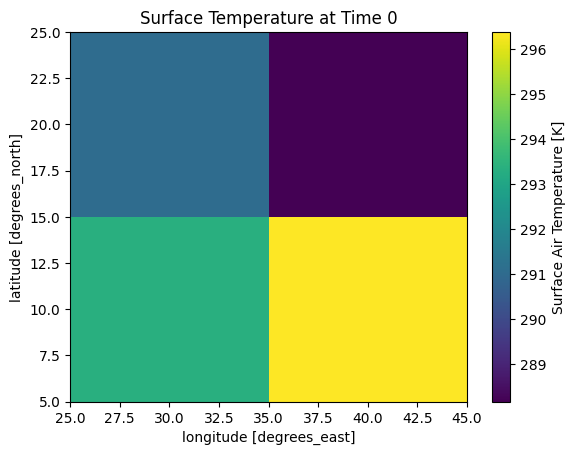

In [14]:
from matplotlib import pyplot as plt

merged_ds = xr.open_dataset(merged_file_path, engine="netcdf4")
temperature = merged_ds["temperature"]

time = 0
# Plot a 2D slice (e.g., first time step)
temperature.isel(time=time).plot()  # Use correct dimension names like lat/lon
plt.title(f"Surface Temperature at Time {time}")
plt.show()

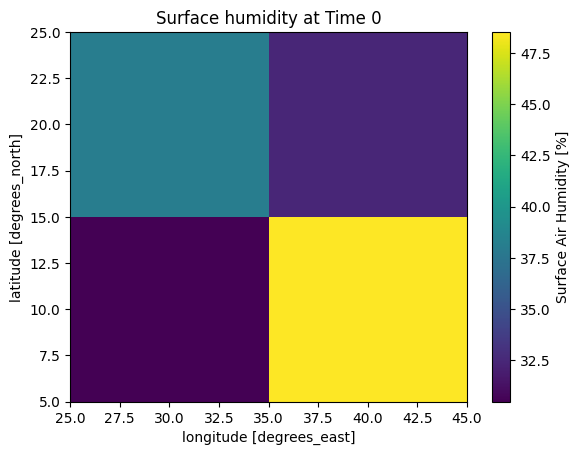

In [15]:
humidity = merged_ds["humidity"]


# Plot a 2D slice (e.g., first time step)
humidity.isel(time=time).plot()  # Use correct dimension names like lat/lon
plt.title(f"Surface humidity at Time {time}")
plt.show()

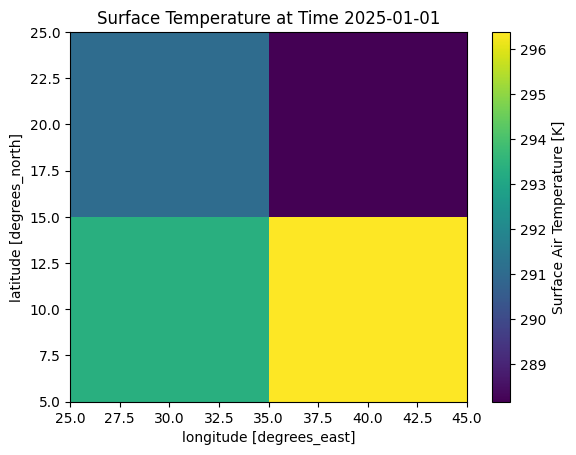

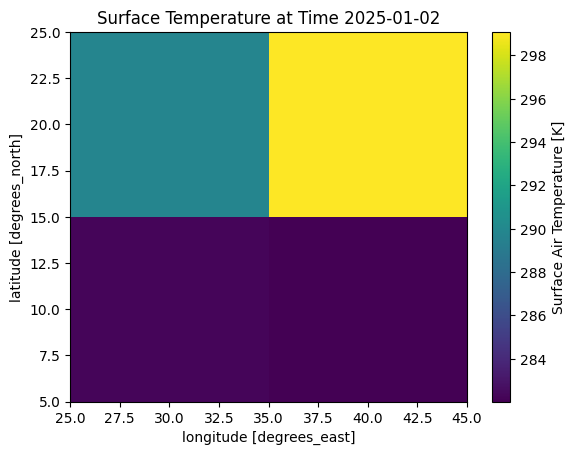

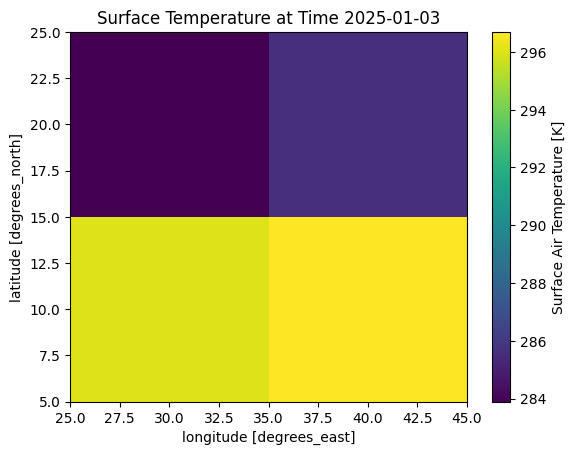

In [16]:
for t in range(len(temperature.time)):
    plt.figure()
    temperature.isel(time=t).plot()
    plt.title(f"Surface Temperature at Time {str(temperature.time.values[t])[:10]}")
    plt.show()

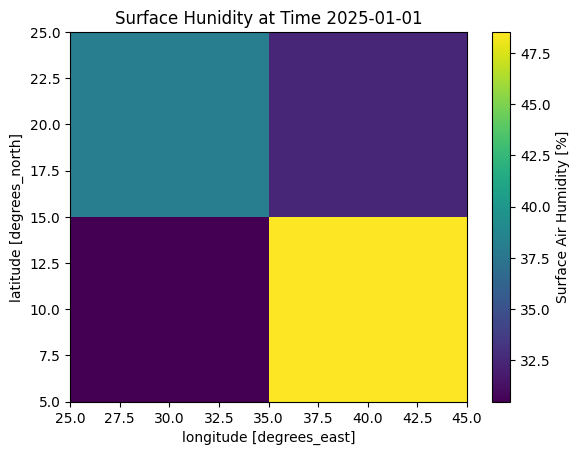

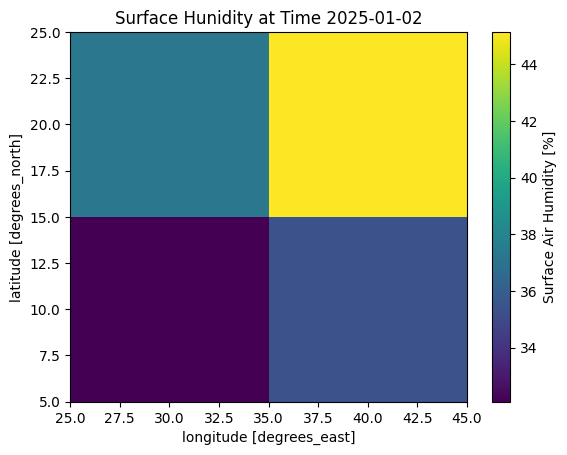

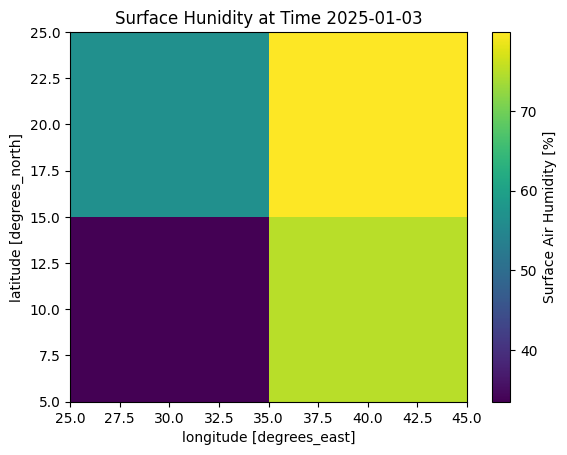

In [17]:
for t in range(len(humidity.time)):
    plt.figure()
    humidity.isel(time=t).plot()
    plt.title(f"Surface Hunidity at Time {str(humidity.time.values[t])[:10]}")
    plt.show()

## 3: Advance merge to reduce file size

There are many ways to reduce netcdf file size. In the below example, we will try to reduce precision 

- Reduce data precision
- Data compression



In [9]:
files = ['day1.nc', 'day2.nc', 'day3.nc']

ad_merged_file_path =f'{file_root_path}/ad_merged_temperature.nc'

ad_data_list = [xr.open_dataset(f"{file_root_path}/{file}", engine="netcdf4") for file in files]

for i, ds in enumerate(ad_data_list):
   ad_data_list[i]["temperature"] = ds["temperature"].astype(np.float32)
   ad_data_list[i]["humidity"] = ds["humidity"].astype(np.float32)


ad_merged = xr.concat(ad_data_list, dim='time')

# Compression settings
encoding = {
    "temperature": {"zlib": True, "complevel": 4, "dtype": "float32", "_FillValue": -999.0, "chunksizes": (1, 2, 2)},
    "humidity": {"zlib": True, "complevel": 4, "dtype": "float32", "_FillValue": -1.0, "chunksizes": (1, 2, 2)},
}

# Step 3: Save the merged dataset
ad_merged.to_netcdf(ad_merged_file_path, engine='netcdf4', encoding=encoding)

# Optional: Print dataset summary
print(ad_merged)

<xarray.Dataset> Size: 152B
Dimensions:      (time: 3, lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
  * time         (time) datetime64[ns] 24B 2025-01-01 2025-01-02 2025-01-03
Data variables:
    temperature  (time, lat, lon) float32 48B 293.3 296.4 291.0 ... 283.9 285.6
    humidity     (time, lat, lon) float32 48B 30.48 48.53 38.06 ... 56.66 79.9
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-06-16
    Conventions:  CF-1.8
